Order in which Gessert did it 

1. Preprocessing
- cropping the black edges out
- shades of grey consistency method


2. Augmentation
- augmentation (flipping, contrast etc)/ they also said they tried using AutoAugment policy
- CutOut (1 hole and size of 16)

Things I wanrt to add in - hair removal (within preprocessing )

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
#from Preprocessing_Utils.Serializer import  Serialize_Write
import cv2
from google.colab.patches import cv2_imshow
import numpy as np



In [20]:
# hair removal- commonly done in alot of peoples approaches however I cant see it within Gesserts work 

# this repo has both hair rmeoval code and colour consistancy https://github.com/ThiruRJST/Melanoma_Classification 

class HairRemoval(object):
        """
        Hair removal code
        https://github.com/ThiruRJST/Melanoma_Classification 
        """

        def __call__(self, image):
            # convert image to grayScale
            grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

            # kernel for morphologyEx
            kernel = cv2.getStructuringElement(1, (17, 17))

            # apply MORPH_BLACKHAT to grayScale image
            blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

            # apply thresholding to blackhat
            _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

            # inpaint with original image and threshold image
            final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)

            return final_image


class ShadesOfGrey(object):
        """
        Code from https://github.com/ThiruRJST/Melanoma_Classification
        imgage (numpy array): the original image with format of (h, w, c)
        power (int): the degree of norm, 6 is used in reference paper
        gamma (float): the value of gamma correction, 2.2 is used in reference paper
        """

        def __init__(self, power=6, gamma=2.2):
            self.power = power
            self.gamma = gamma

        def __call__(self, image):
            image_dtype = image.dtype

            if self.gamma is not None:
                image = image.astype('uint8')
                look_up_table = np.ones((256, 1), dtype='uint8') * 0
                for i in range(256):
                    look_up_table[i][0] = 255 * pow(i / 255, 1 / self.gamma)
                image = cv2.LUT(image, look_up_table)

            image = image.astype('float32')
            image_power = np.power(image, self.power)
            rgb_vec = np.power(np.mean(image_power, (0, 1)), 1 / self.power)
            rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
            rgb_vec = rgb_vec / rgb_norm
            rgb_vec = 1 / (rgb_vec * np.sqrt(3))
            image = np.multiply(image, rgb_vec)

            # Andrew Anikin suggestion
            image = np.clip(image, a_min=0, a_max=255)

            return image.astype(image_dtype)
    
class CropBlackCircle(object):
    """
    https://stackoverflow.com/questions/61986407/crop-x-ray-image-to-remove-black-background 
    """
    def __call__(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # threshold 
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
        hh, ww = thresh.shape

        # make bottom 2 rows black where they are white the full width of the image
        thresh[hh-3:hh, 0:ww] = 0

        # get bounds of white pixels
        white = np.where(thresh==255)
        xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

        # crop the image at the bounds adding back the two blackened rows at the bottom
        crop = image[ymin:ymax+3, xmin:xmax]

        return crop


In [ ]:
# cropping out black border unfortunately Gessert uses Matlab for doing this https://github.com/ngessert/isic2019/blob/2394aaf60e7e070a5d0197a381426a1259a5f1bb/Matlab/adjust_2019.m 

# "We binarize the images with a very low threshold, such that the entire dermoscopy field of view is set to 1. Then, we find the center of mass and the major and minor axis of an ellipse that has the same second central moments as the inner area. Based on these values we derive a rectangular bounding box for cropping that covers the
# relevant field of view. We automatically determin the necessecity for cropping based on a heuristic that tests whether the mean intensity inside the bounding box is substantially different from the mean intensity outside of the bounding box."

# ALTERNATIVELY THIS METHOD ON stack OVERFLOW https://stackoverflow.com/questions/61986407/crop-x-ray-image-to-remove-black-background 

# could develop this by cropping the image more to omit more of the black egdes or look into inpainting https://github.com/fitushar/Skin-lesion-Segmentation-using-grabcut/blob/master/Skin%20lesion%20segmentation%20using%20grabcut%20in%20HSV%20color%20space.pdf 





In [ ]:
# Augmentation 

# CURRENT 
transform=transforms.Compose([
                            transforms.RandomVerticalFlip(0.5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(),
                                                            transforms.GaussianBlur(3)]), p=0.1),
                            ImageResize(224,224),
                            transforms.PILToTensor(),
                            transforms.ConvertImageDtype(torch.float),
                            transforms.Normalize(*Imagenet_NV),
)

# From Gessert however this doesnt match up with the paper??? The paper also mentions shear and other augmentation 

transform = transforms.Compose([
                    cropping,
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize(torch.from_numpy(self.setMean).float(),torch.from_numpy(np.array([1.,1.,1.])).float())
                    ])   

# AutoAugment , code example of useage is here https://towardsdatascience.com/how-to-improve-your-image-classifier-with-googles-autoaugment-77643f0be0c9 
# want to try using the Three autoaugment pretrined polices (for ImageNet, CIFAR10, SVHM) https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py 
# also examples of how to use Autoaugment with Pytorch https://github.com/DeepVoltaire/AutoAugment 

# further exploration of a paper that just focuses on augmentation of skin lesions https://github.com/fabioperez/skin-data-augmentation/blob/91c6109796b23b0bf174632937474853b9559460/auglib/augmentation/augmentations.py#L71 

In [17]:
# Gessert also inclues CutOut with is added into the transforms as (Cutout_v0(n_holes=1,length=self.mdlParams['cutout']))

class Cutout_v0(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        img = np.array(img)
        #print(img.shape)
        h = img.shape[0]
        w = img.shape[1]

        mask = np.ones((h, w), np.uint8)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        #mask = torch.from_numpy(mask)
        #mask = mask.expand_as(img)
        img = img * np.expand_dims(mask,axis=2)
        img = Image.fromarray(img)
        return img    

In [22]:
#TESTING HAIR REMOVAL FEATURE and black circle cut out
def hairremoval(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1, (17, 17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)

    return final_image

def CropCircle(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # threshold 
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
        hh, ww = thresh.shape

        # make bottom 2 rows black where they are white the full width of the image
        thresh[hh-3:hh, 0:ww] = 0

        # get bounds of white pixels
        white = np.where(thresh==255)
        xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

        # crop the image at the bounds adding back the two blackened rows at the bottom
        crop = image[ymin:ymax+3, xmin:xmax]

        return crop

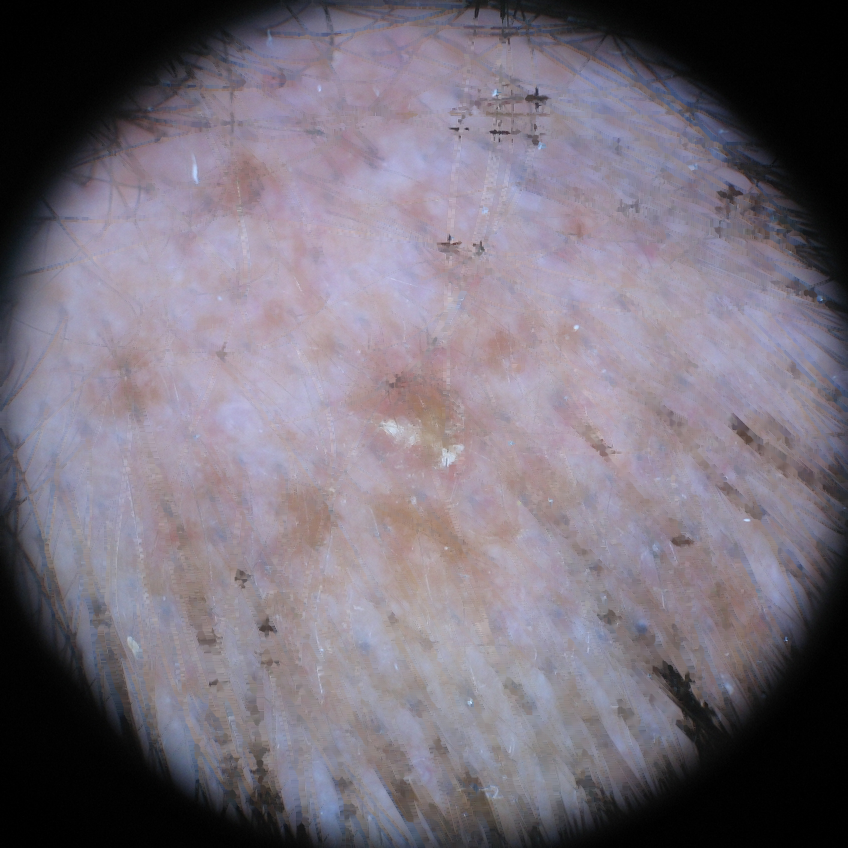

In [25]:
img = cv2.imread('/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Split_val/test/AK/ISIC_0060404.jpg')
cut_out_img = CropCircle(img)
#cv2_imshow(img)
test_hair_removed = hairremoval(cut_out_img)
cv2_imshow(test_hair_removed)